In [163]:
import keras
print(keras.__version__)

3.6.0


In [164]:
import numpy as np
import matplotlib.pyplot as plt


In [165]:
def conical_surface(eccentricity, num_points=100):
    if eccentricity < 0:
        raise ValueError("Eccentricity must be non-negative.")
    
    t = np.linspace(-np.pi, np.pi, num_points)
    a =1.0
    if eccentricity < 1:  # Ellipse
        b = a * np.sqrt(1 - eccentricity**2)
        x = a * np.cos(t)
        y = b * np.sin(t)
    elif eccentricity == 1:  # Parabola
        x = 2 * a * t
        y = t**2 
    else:  # Hyperbola
        b = a * np.sqrt(eccentricity**2 - 1)
        y = a * np.cosh(t)
        x = b * np.sinh(t)
    
    return x, y

In [166]:
e=1.1
x,y = conical_surface(e,1000)

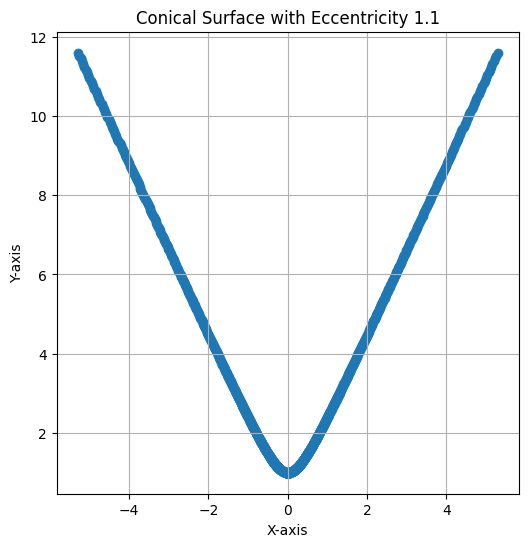

In [167]:
plt.figure(figsize=(6, 6))
plt.scatter(x, y)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(f'Conical Surface with Eccentricity {e}')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True)
plt.show()

In [168]:
def generate_elipses(e,a=1,num_points=100):
    t = np.linspace(-np.pi, np.pi, num_points)
    
    b = a * np.sqrt(1 - e**2)
    x = a * np.cos(t)
    y = b * np.sin(t)
    return x,y

In [169]:
def apply_rotation_translation(x,y,xt=0,yt=0,angle_rad=0):
    xf = xt + x * np.cos(angle_rad) - y * np.sin(angle_rad)
    yf = yt + x * np.sin(angle_rad) + y * np.cos(angle_rad)
    return xf,yf

[]

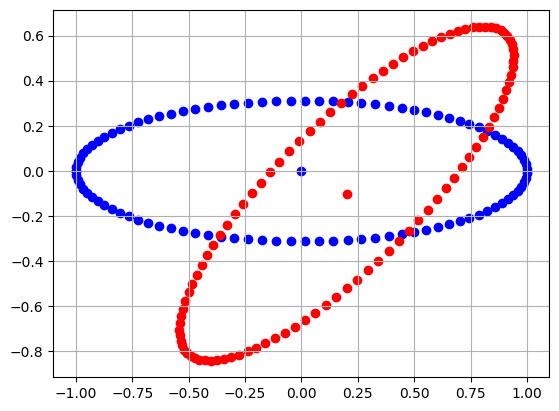

In [170]:
testex,testey=generate_elipses(0.95,1,100)
xt=0.2
yt=-0.1
tx,ty=apply_rotation_translation(testex,testey,xt,yt,np.pi/4)
plt.scatter(testex,testey,color="blue")
plt.scatter(0,0,color="blue")
plt.scatter(tx,ty,color="red")
plt.scatter(xt,yt,color="red")
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
plt.plot()

In [ ]:
import random
x_values = []
y_values = []
samples=50000
num_points=100
e_values=np.random.rand(samples)
a_values=100*np.random.rand(int(samples))

angle_values=2*np.pi*np.random.rand(samples)
xt_values=100*np.random.rand(samples)
yt_values=100*np.random.rand(samples)

for e,a,angle,xt,yt in zip(e_values,a_values,angle_values,xt_values,yt_values):
    x,y=generate_elipses(e,a,num_points)
    xf,yf=apply_rotation_translation(x,y,xt,yt,angle)
    x_values.append(xf)  # Append x values to list
    y_values.append(yf)  # Append y values to list



In [172]:
#lets add noise
x_noise=[]
y_noise=[]

noise_level=0.5

for a,x in zip(a_values,x_values):
    noisex= np.random.normal(loc=0,scale=a/15,size=num_points)
    x_noise.append(noisex+x)
for a,y in zip(a_values,y_values):
    noisey= np.random.normal(loc=0,scale=a/15,size=num_points)
    y_noise.append(noisey+y)

#x_noise=x_values+a_values*noisex
#y_noise=y_values*a_values*noisey


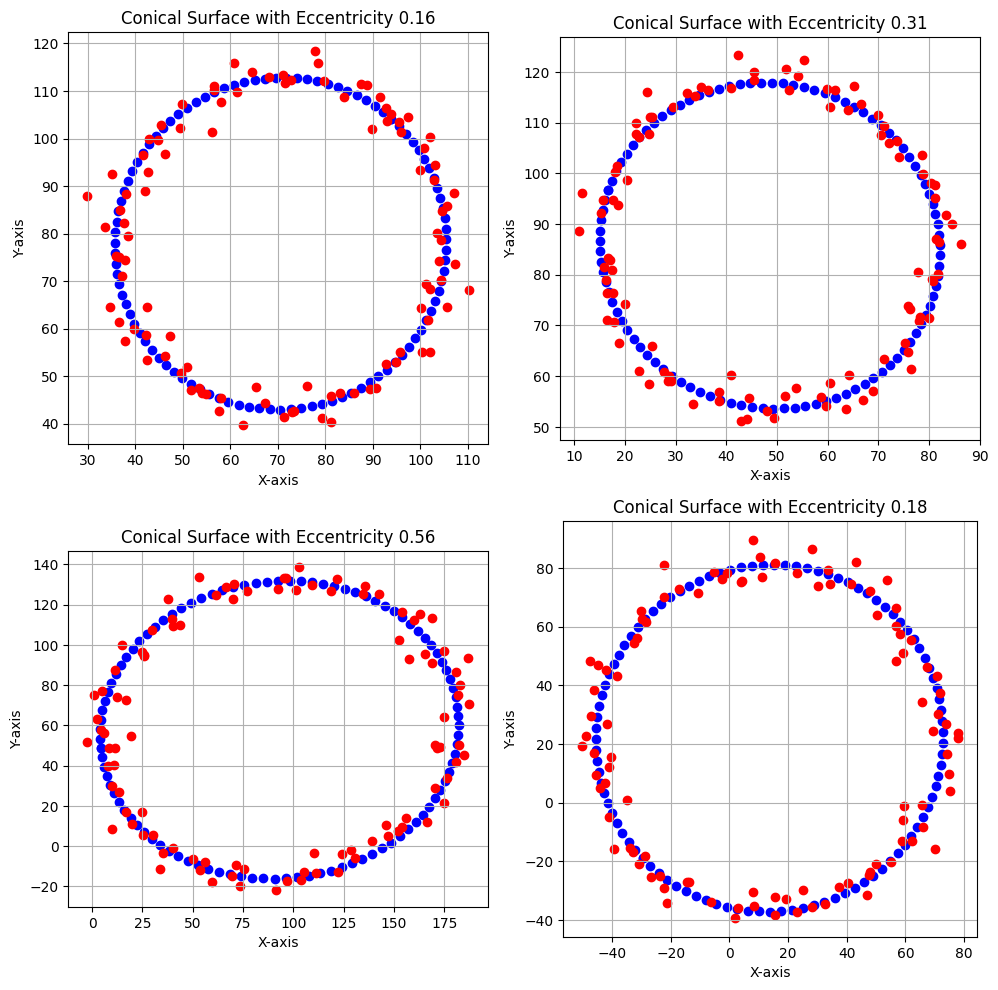

In [173]:
num_plots = 4
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Randomly choose 4 indices to plot
indices_to_plot = np.random.choice(samples, 4, replace=False)

# Plotting each subplot
for i, idx in enumerate(indices_to_plot):
    row = i // 2  # Determine row index (0 or 1)
    col = i % 2   # Determine column index (0 or 1)
    
    axs[row, col].scatter(x_values[idx], y_values[idx],color='blue')
    axs[row, col].scatter(x_noise[idx], y_noise[idx],color='red')

    axs[row, col].set_aspect('equal', adjustable='box')
    axs[row, col].set_title(f'Conical Surface with Eccentricity {e_values[idx]:.2f}')
    axs[row, col].set_xlabel('X-axis')
    axs[row, col].set_ylabel('Y-axis')
    axs[row, col].grid(True)

plt.tight_layout()
plt.show()

In [174]:
#rede neural
#import tensorflow as tf
#from tensorflow import keras
from keras import models,layers,initializers

In [175]:
#input_data = [(x_noise[i], y_noise[i]) for i in range(len(x_noise))]
#input_data_flat = input_data.reshape((input_data.shape[0], -1))
input_data = np.concatenate([x_noise,y_noise],1)
output_data = np.column_stack([e_values])#,a_values])
print(input_data.shape)
print(e_values.shape)
print(output_data.shape)
print(len(input_data[0]))



(10000, 200)
(10000,)
(10000, 1)
200


In [176]:
def prepare_data(x,y):
    return np.concatenate([x_noise,y_noise],1)

In [177]:
# Criar o modelo sequencial
model = models.Sequential(name="my_neural")
model.add(layers.Input(shape=(2 * num_points,)))
model.add(layers.BatchNormalization())
model.add(layers.Dense(2000, activation="relu", kernel_initializer="he_normal"))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))  # Adicionando Dropout
model.add(layers.Dense(1000, activation="tanh", kernel_initializer="he_normal"))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))  # Adicionando Dropout
model.add(layers.Dense(2000, activation="relu", kernel_initializer="he_normal"))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))  # Adicionando Dropout
model.add(layers.Dense(1, activation="linear"))  # Saída com duas unidades, uma para 'a' e outra para 'e'

model.compile(optimizer="adam",loss="mse",metrics=["mean_squared_error"])

model.summary()


Model: "my_neural"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_24          │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 2000)           │       402,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 2000)           │         8,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1000)           │     2,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 1000)           │         4,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 2000)           │     2,002,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 2000)           │         8,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │         2,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,427,801 (16.89 MB)

 Trainable params: 4,417,401 (16.85 MB)

 Non-trainable params: 10,400 (40.62 KB)

In [ ]:
#separando os dados
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(input_data,output_data,random_state=42)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)



In [179]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(x_train,y_train,epochs=100,batch_size=100,validation_data=(x_test,y_test),callbacks=[early_stopping])

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - loss: 8.7229 - mean_squared_error: 8.7229 - val_loss: 1.3551 - val_mean_squared_error: 1.3551
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - loss: 1.0358 - mean_squared_error: 1.0358 - val_loss: 0.3429 - val_mean_squared_error: 0.3429
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - loss: 0.7029 - mean_squared_error: 0.7029 - val_loss: 0.2165 - val_mean_squared_error: 0.2165
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - loss: 0.5938 - mean_squared_error: 0.5938 - val_loss: 0.1134 - val_mean_squared_error: 0.1134
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - loss: 0.4672 - mean_squared_error: 0.4672 - val_loss: 0.0874 - val_mean_squared_error: 0.0874
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - loss: 0.3455 - mean_squared_error: 0.3455 - val_loss: 0.0992 - val_mean_squared_error: 0.0992
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - loss: 0.2876 - mean_squared_error: 0.2876 - val_loss:

In [180]:
# Accessing the training loss history
training_loss = history.history['loss']

# Accessing the validation loss history
validation_loss = history.history['val_loss']

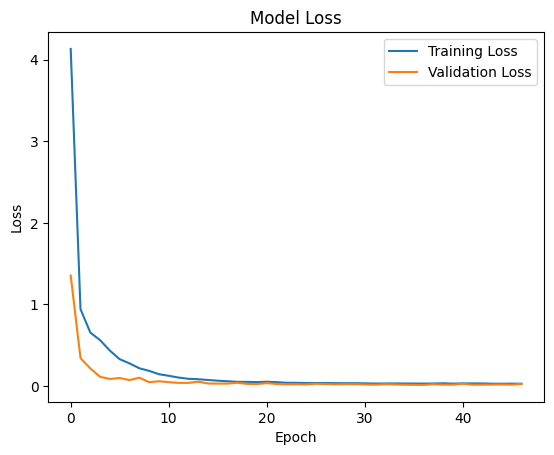

In [181]:
# Plot training & validation loss values
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')

plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [192]:
e=0.25
a=100

x_teste,y_teste = generate_elipses(e,a,100)
teste=np.concatenate([x_teste,y_teste])
# Reshape teste to match the expected input shape of your model
teste = np.expand_dims(teste, axis=0)  # Shape will be (1, 200)
teste = scaler.transform(teste)
pred=model.predict(teste)

print(pred)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[[0.1067172]]


In [183]:
x_train[2]

array([-0.3480257 , -0.58494467, -0.63442024, -0.85493687, -0.90217229,
       -0.96260519, -0.9831923 , -0.99411782, -1.17501237, -1.09756684,
       -1.48583763, -1.39214021, -1.60975709, -1.52485371, -1.64320973,
       -1.72466381, -1.73934343, -1.73182729, -1.63888181, -1.62271285,
       -1.53984266, -1.84494865, -1.66648321, -1.84734525, -1.40449492,
       -1.73642193, -1.71104859, -1.87356378, -1.59468085, -1.2722959 ,
       -1.4531138 , -1.25355596, -1.0854371 , -0.94565217, -0.86689542,
       -1.06544706, -0.90251499, -0.93222775, -0.71630674, -0.64301817,
       -0.53176528, -0.43679002, -0.281138  , -0.1793074 , -0.1956824 ,
        0.12523074,  0.12310538,  0.12970125,  0.22749519,  0.2996343 ,
        0.49619518,  0.66722191,  0.71097806,  0.62447262,  0.94240303,
        1.12015624,  1.01256617,  0.77550309,  1.20920078,  1.37366563,
        1.35414594,  1.31441523,  1.29129529,  1.42670203,  1.60982075,
        1.57814831,  1.4416649 ,  1.6178638 ,  1.56540067,  1.75

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


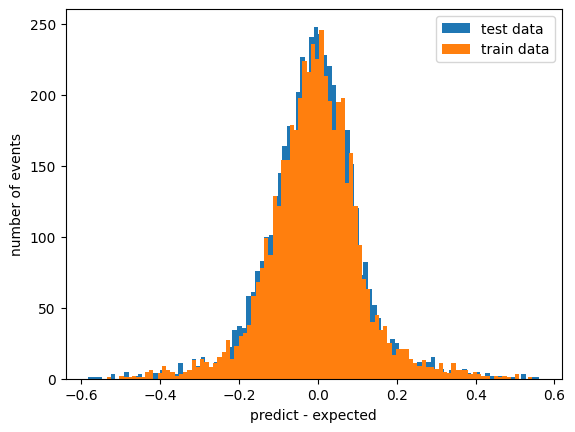

In [197]:
predict=model.predict(x_test)
plt.hist(predict-y_test,bins=100,label="test data")
predict=model.predict(x_train)
plt.hist(predict-y_train,bins=100,label="train data")
plt.xlabel("predict - expected")
plt.ylabel("number of events")
plt.legend()

In [185]:
output_data[8]

array([0.66384499])